### Introduction
This code walks through the process of post-processing and analyzing the coefficient of lift from cylinder flow simulations.

The coefficient of lift of a two-dimensional body is defined as:
$$ C_l = \frac{2l}{\rho u^2 L}, $$

where $l$ is the two-dimensional lift force, $\rho$ is the fluid density, $u$ is the freestream fluid velocity, and $L$ is a reference length of the body. $C_l$ is a nondimensional measure of the lifting force on the body, and when this force varies with time as $l(t)$, then the $C_l(t)$ becomes a function of time as well.

In the case of cylinder vortex shedding, the vortices being shed off the back and sides of the cylinder are regions of low pressure, hence a time-dependent pressure distribution leading to a time-dependent force on the body and thus coefficient of lift.

The development from a zero initial condition to a period of transient growth and final saturation onto a limit cycle is characteristic of a Hopf bifurcation, modeled by the complex Stuart-Landau equation:

$$ \frac{d}{dt} A = \lambda A - \mu |A|^2 A ,$$

where $A = A_r + \mathbb{i} A_i$ is the complex solution of this ordinary differential equation (ODE) and $\lambda$ and $\mu$ are parameters. This complex ODE can be written as a system of coupled real ODEs:

$$ A_r = u \; \; \Rightarrow \; \; \frac{\partial u}{\partial t} = \lambda_r u - \lambda_i v - (u^2 + v^2) (\mu_r u - \mu_i v) + \kappa_r u_{x} - \kappa_i v_{x} + \gamma_r u_{xx} - \gamma_i v_{xx} $$

$$ A_i = v \; \; \Rightarrow \; \; \frac{\partial v}{\partial t} = \lambda_i u + \lambda_r v - (u^2 + v^2) (\mu_i u + \mu_r v) + \kappa_i u_{x} + \kappa_r v_{x} + \gamma_i u_{xx} + \gamma_r v_{xx} $$

We seek a Stuart-Landau model for the dynamics of $C_l(t)$. However $C_l(t)$ is only a single real signal, hence first we will raise the dimension of the system by including a second signal $\eta$. This second signal may be produced either by _time-delay embedding_ or _time-differentiating_ the original signal. These methods both produce a second periodic signal but out of phase with the first signal. This pair of signals emulates the normal pairing of real and complex parts of an amplitude in the Stuart-Landau equation.

Then we will use the Sparse Identification of Nonlinear Dynamics (SINDy) algorithm to identify a sparse model to explain the dynamics of this pair of signals. 



In [1]:
###  Import modules

import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps
import json

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


###  Load the analysis settings and parameters

#  Load the configuration file with all settings
with open('Lift-config.json', 'r') as f:
    config = json.load(f)

#  Read out and import all variables
for key, value in config.items():  print(f"{key}: {value}")
globals().update(config)



Re: 50
l_d_flag: lift
t_trm_1: 25000
t_trm_2: 50000
TDE_or_ddt: TDE
TD_Embed: 2
threshold: 0
diff_order: 2
poly_order: 5
should_normalize: 1
n_terms: 10
_comment: n_terms must be manually updated based on value of "poly_order": (3,10) or (5,)


In [2]:
%%javascript
require("notebook/js/notebook").Notebook.prototype.scroll_to_bottom = function () {}

<IPython.core.display.Javascript object>

# The coefficients of lift and drag
The simulations begin with an initial condition of zero velocity everywhere. As the flow is developing, the coefficients of lift and drag being to oscillate and undergo a period of transient growth before saturating onto a limit cycle and exhibiting regular periodic behavior.

By specifying the parameter `l_d_flag` in the `lift-config.json` file, the user may specify using either the lift or the drag as the signal upon which to base our model discovery.



In [3]:
###  Load data

from LoadData_lift import fnc_LoadData_lift
t , C_l , C_d , dt = fnc_LoadData_lift( Re , t_trm_1 , t_trm_2 )



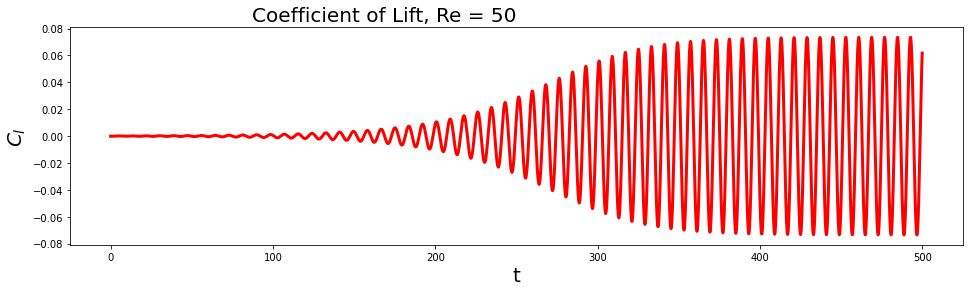

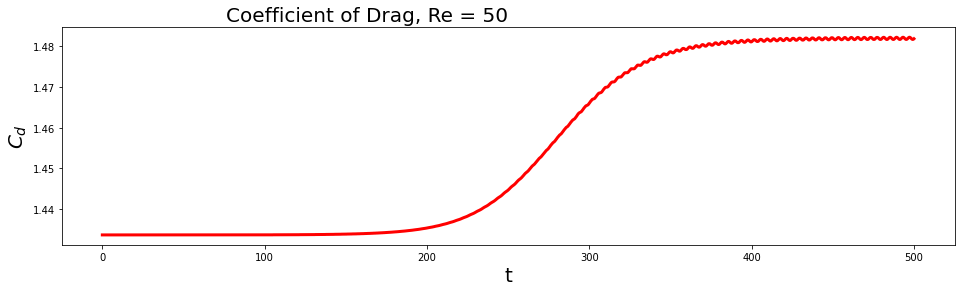

In [4]:
###  Lift

plt.figure(figsize=(16, 4))
plt.plot(t, C_l,  linewidth=3, color='r')
plt.xlabel('t', fontsize=20)
plt.ylabel('$C_l$', fontsize=20)
ttl_str = 'Coefficient of Lift, Re = ' + str(Re)
plt.title(ttl_str, fontsize=20, horizontalalignment='right')
plt.show()


###  Drag

plt.figure(figsize=(16, 4))
plt.plot(t, C_d,  linewidth=3, color='r')
plt.xlabel('t', fontsize=20)
plt.ylabel('$C_d$', fontsize=20)
ttl_str = 'Coefficient of Drag, Re = ' + str(Re)
plt.title(ttl_str, fontsize=20, horizontalalignment='right')
plt.show()



# Raising the dimension of the system
We raise the dimension of the system by either time-delay embedding or time-differentiating.

In order to find a Stuart-Landau-like model for the dynamics of $C_l(t)$, we require a system of two real signals. We may obtain a second signal from $C_l(t)$ by either _time-delay embedding_ or _time-differentiating_ the original signal. These methods both produce a second periodic signal but out of phase with the first signal.

However, time-differentiating introduces additional numerical errors to the data whereas time-delay embedding does not. Furthermore, including time-differentiated signal to the base system may introduce additional dynamics not captured a Stuart-Landau-like model.

The user my choose either time-delay embedding or time-differentiating as the method of raising the dimension. In the file `lift-config.json`, specify the flag `TDE_or_ddt` as either `TDE` or `ddt`.

The system of data is plotted below.



In [5]:
###  Raise dimension of system by either time-delay embedding or time-differentiating

from raiseDim_lift import fnc_raiseDim_lift
t_PS , data_1 , data_2 = \
fnc_raiseDim_lift( TDE_or_ddt , t , TD_Embed, C_l , C_d , l_d_flag , should_normalize)




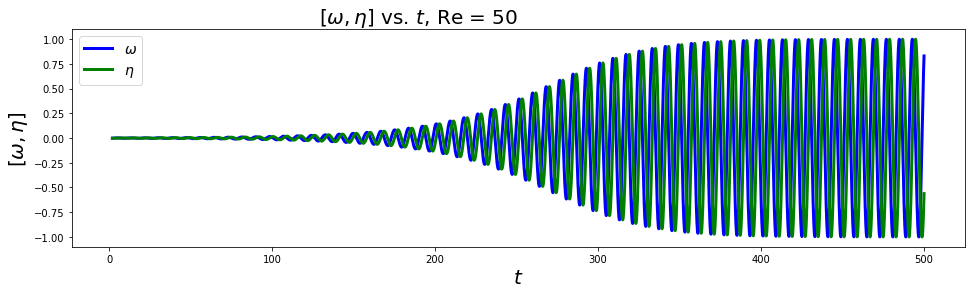

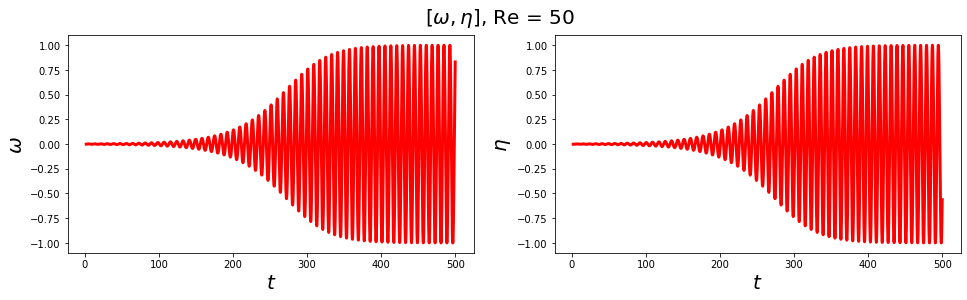

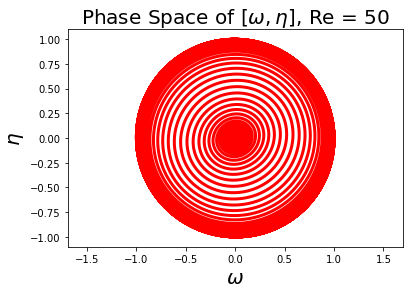

In [6]:
###  Both on same plot

plt.figure(figsize=(16, 4))
plt.plot(t_PS, data_1 ,  linewidth=3, color='b' , label='$\omega$' ) # 
plt.plot(t_PS, data_2 ,  linewidth=3, color='g' , label='$\eta$' ) # 
plt.xlabel('$t$', fontsize=20)
plt.ylabel('$[\omega, \eta]$', fontsize=20)
ttl_str = '$[\omega, \eta]$ vs. $t$, Re = ' + str(Re)
plt.title(ttl_str, fontsize=20, horizontalalignment='right')
plt.legend(fontsize=14)
plt.show()


###  Each on separate plots 

plt.figure(figsize=(16, 4))
ttl_str = r'$[\omega, \eta]$, Re = ' + str(Re)
plt.suptitle(ttl_str, fontsize=20, horizontalalignment='center')

plt.subplot(1, 2, 1)
plt.plot(t_PS, data_1,  linewidth=3, color='r') # 
plt.xlabel('$t$', fontsize=20)
plt.ylabel('$\omega$', fontsize=20)

plt.subplot(1, 2, 2)
plt.plot(t_PS, data_2,  linewidth=3, color='r') # 
plt.xlabel('$t$', fontsize=20)
plt.ylabel('$\eta$', fontsize=20)

plt.show()


###  Phase space

plt.figure()
plt.plot(data_1, data_2,  linewidth=3, color='r') # 
plt.xlabel('$\omega$', fontsize=20)
plt.ylabel('$\eta$', fontsize=20)
ttl_str = 'Phase Space of $[\omega, \eta]$, Re = ' + str(Re)
plt.title(ttl_str, fontsize=20)
plt.axis('equal')
plt.show()



In [7]:
###  Compare amplitudes of the two signals

# print('')
# print('Max of zeta = ' + str(np.max(zeta)) )
# print('Max of eta  = ' + str(np.max(eta)) )
# print('\n')


# peak_guess_range_finder = int(TD_Embed/dt * 4)
# np.max( zeta[-peak_guess_range_finder:-1]  )
# np.argmax( zeta[-peak_guess_range_finder : -1 ]  )
# np.max( eta[-peak_guess_range_finder:-1]  )
# np.argmax( eta[-peak_guess_range_finder : -1 ]  )



# SINDy
Next, we run the SINDy algorithm on the system $\mathcal{U} = [\omega, \eta]$. We seek a system of ODEs to model $\mathcal{U}_t = [\omega, \eta_t]$. We fit an ODE with terms from the following library:

$$ \Theta = [ \; \omega, \eta, \omega^2, \omega \eta, \eta^2, \omega^3, \omega^2\eta, \omega \eta^2, \eta^3 \; ] $$



In [12]:
###  Initiate and run SINDy

from runSINDy import fnc_runSINDy
model , coefs , x_test_sim , error_1 , error_2 , NRMSE_1 , NRMSE_2 , NRMSE_sys = \
fnc_runSINDy( data_1 , data_2 , t_PS , dt , diff_order , poly_order , threshold)


print('\nx = zeta')
print('y = eta\n\n')
model.print(precision=10)
print('\n')




x = zeta
y = eta


(x)' = 0.0000045854 1 + 0.0905200892 x + -0.7749126664 y + -0.0000002130 x^2 + -0.0000014359 x y + -0.0000002693 y^2 + -0.1259511423 x^3 + -0.0178139592 x^2 y + -0.1311078839 x y^2 + -0.0278830619 y^3 + 0.0000037098 x^4 + 0.0000029499 x^3 y + 0.0000021321 x^2 y^2 + 0.0000051083 x y^3 + 0.0000022592 y^4 + 0.0301506117 x^5 + 0.0026603362 x^4 y + 0.0655630512 x^3 y^2 + 0.0169508255 x^2 y^3 + 0.0356187041 x y^4 + 0.0142247957 y^5
(y)' = -0.0000044249 1 + 0.7100722980 x + -0.0470892642 y + -0.0000013348 x^2 + -0.0000004179 x y + 0.0000012876 y^2 + 0.0952492972 x^3 + 0.0655662862 x^2 y + 0.0976557943 x y^2 + 0.0791396057 y^3 + -0.0000012698 x^4 + -0.0000021014 x^3 y + -0.0000032340 x^2 y^2 + -0.0000014786 x y^3 + -0.0000045208 y^4 + -0.0167526397 x^5 + -0.0120818962 x^4 y + -0.0348641512 x^3 y^2 + -0.0390011115 x^2 y^3 + -0.0182913909 x y^4 + -0.0269113776 y^5




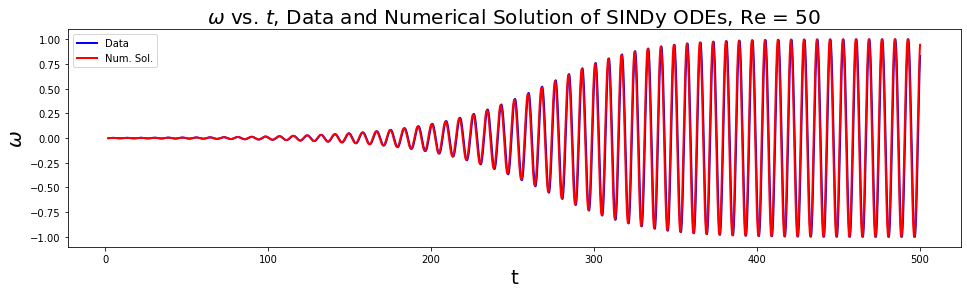

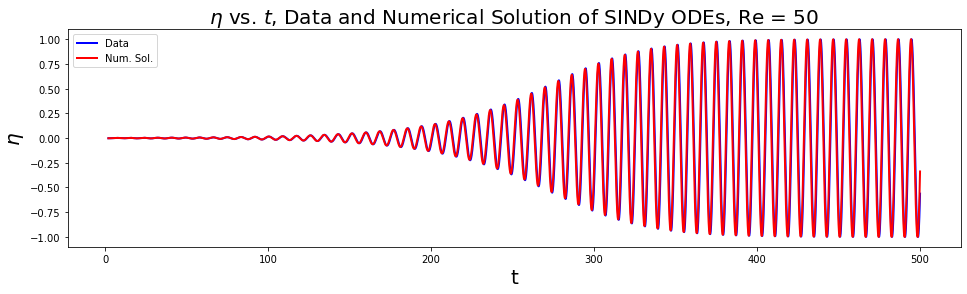

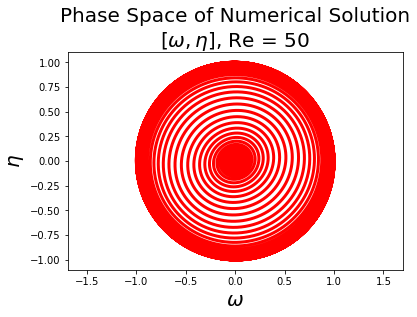

In [9]:
###  Plot the data and the numerical solution of the SINDy ODEs

plt.figure(figsize=(16, 4))
plt.plot(t_PS, data_1         ,  linewidth=2, color='b', label='Data') # 
plt.plot(t_PS, x_test_sim[:,0],  linewidth=2, color='r', label='Num. Sol.') # 
plt.xlabel('t', fontsize=20)
plt.ylabel('$\omega$', fontsize=20)
ttl_str = '$\omega$ vs. $t$, Data and Numerical Solution of SINDy ODEs, Re = ' + str(Re)
plt.title(ttl_str, fontsize=20)
plt.legend()
plt.show()

plt.figure(figsize=(16, 4))
plt.plot(t_PS, data_2,           linewidth=2, color='b', label=r'Data') # 
plt.plot(t_PS, x_test_sim[:,1],  linewidth=2, color='r', label='Num. Sol.') # 
plt.xlabel('t', fontsize=20)
plt.ylabel('$\eta$', fontsize=20)
ttl_str = '$\eta$ vs. $t$, Data and Numerical Solution of SINDy ODEs, Re = ' + str(Re)
plt.title(ttl_str, fontsize=20)
plt.legend()
plt.show()


###  Phase space

plt.figure()
plt.plot(x_test_sim[:,0], x_test_sim[:,1],  linewidth=3, color='r') # 
plt.xlabel('$\omega$', fontsize=20)
plt.ylabel('$\eta$', fontsize=20)
ttl_str = 'Phase Space of Numerical Solution\n'+'$[\omega,\eta]$, Re = ' + str(Re)
plt.title(ttl_str, fontsize=20)
plt.axis('equal')
plt.show()



# Compute errors and normalized root-mean-square error (NRMSE)
The _normalized root mean square error_ is a measure of the error between the data and the numerical solution of its SINDy ODE. First we construct the error vector for each signal within $\mathcal{U}$:
$$ \epsilon_i = \mathcal{U}_i - \mathcal{U}^{*}_i .$$

Then we compute the square root of the sum of the errors, and normalize by the square root of the sum of the data.

$$ \text{NRMSE}_i = \sqrt{ \frac{ \sum_{t} \epsilon_i^2 }{ \sum_{t} \mathcal{U}_i^2 } } .$$

Finally, we could compute the NRMSE of the system by computing the $l_2$ norm of the NRMSEs of each signal.

$$ \text{NRMSE}_{sys} = \sqrt{ \text{NRMSE}_1^2 + \text{NRMSE}_2^2 } $$


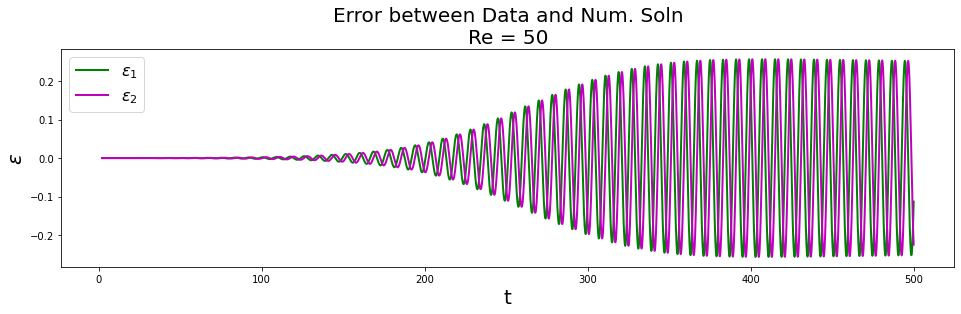



The error between the coefficient of lift system and the numerical solutions of their SINDy ODEs:

Max error on zeta = 0.256234990846377
Max error on eta  = 0.25617846595932686


NRMSE on zeta = 0.2602180058648915
NRMSE on eta  = 0.25888590993769495




NRMSE of the system is:

NRMSE_sys = 0.3670631075722116




In [10]:
###  Plot error

plt.figure(figsize=(16, 4))
plt.plot(t_PS, error_1,  linewidth=2, color='g', label=r'$\epsilon_1$') # 
plt.plot(t_PS, error_2,  linewidth=2, color='m', label=r'$\epsilon_2$') # 
plt.xlabel('t', fontsize=20)
plt.ylabel('$\epsilon$', fontsize=20)
ttl_str = 'Error between Data and Num. Soln' + '\nRe = ' + str(Re)
plt.title(ttl_str, fontsize=20)
plt.legend(loc='upper left', fontsize=16)
plt.show()


print('\n\nThe error between the coefficient of lift system and the numerical solutions of their SINDy ODEs:\n')
print('Max error on zeta = ' + str(np.max(error_1)))
print('Max error on eta  = ' + str(np.max(error_2)))
print('\n')
print('NRMSE on zeta = ' + str(NRMSE_1))
print('NRMSE on eta  = ' + str(NRMSE_2))
print('\n')

print('\n')
print('NRMSE of the system is:\n')
print('NRMSE_sys = '+ str(NRMSE_sys) )
print('\n')

